# TP Aprendizaje supervisado

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

In [ ]:
# General params

RANDOM_STATE = 45
IMPUTE_NULLS = True
ENCODER = OneHotEncoder
TRAIN_SIZE = 0.85

## Carga del data set

In [ ]:
full_train_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/test.csv')
full_train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0


## Análisis exploratorio

In [ ]:
print("Ratio de distribucion de clases {:.4f}".format(len(full_train_df[full_train_df["Transported"] == False]) / len(full_train_df[full_train_df["Transported"] == True])))

Ratio de distribucion de clases 0.9735


### Tratamiento de nulos

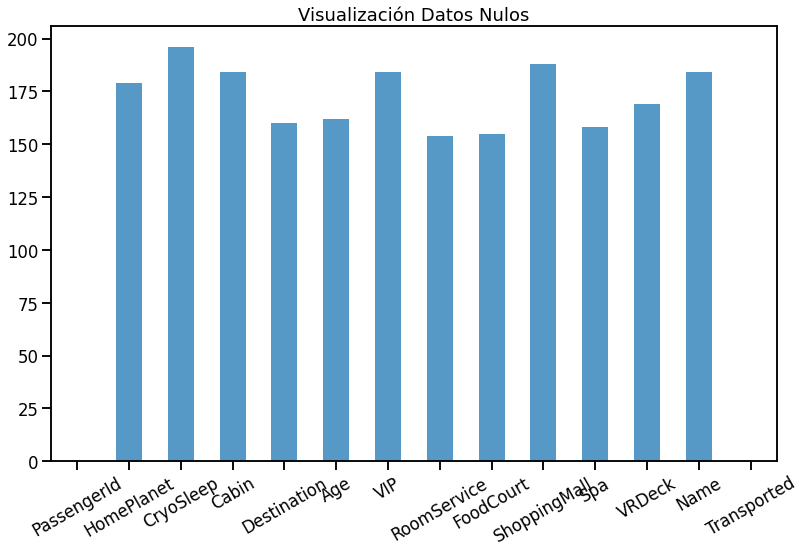

In [ ]:
full_train_df.isna().sum().plot(kind='bar', rot=30, alpha=0.75, figsize=(13,8)).set_title("Visualización Datos Nulos")
plt.show()

In [ ]:
numeric_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService", "CryoSleep", "VIP"]
categorical_cols = ["HomePlanet", "Destination", "Floor", "Side"]

def clean_nulls(df,impute_nulls):
  imputed_full_df = df
  if impute_nulls:
    from sklearn.impute import KNNImputer
    imputer = KNNImputer()
    imputed_full_df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    imputed_full_df = imputed_full_df.dropna()
  else:
    imputed_full_df = df.dropna()
  return imputed_full_df


In [ ]:
imputed_full_df = clean_nulls(full_train_df, IMPUTE_NULLS)
print("Ratio de distribucion de clases luego de eliminar los nan {:.4f}".format(len(imputed_full_df[imputed_full_df["Transported"] == False]) / len(imputed_full_df[imputed_full_df["Transported"] == True])))

print("Validación de que no quedan nulos. Cantidad de nulos: {}".format(imputed_full_df.isna().sum().sum()))

Ratio de distribucion de clases luego de eliminar los nan 0.9740
Validación de que no quedan nulos. Cantidad de nulos: 0


### Selección de columnas y split de valores

In [ ]:
def fit_columns(df):
  # Se elimina la columna name por que no es un dato relevante par el análisis
  if "Name" in df:
    df = df.drop(columns=['Name'])

  # Se separan como distintas features las partes de la culumna 'Cabin'
  if "Cabin" in df:
    df[["Floor","Number","Side"]] = df.Cabin.str.split("/",expand=True)
    df = df.drop(columns = ["Cabin"])
  return df

In [ ]:
imputed_full_df = fit_columns(imputed_full_df)

## Aplicación de encoding para categóricas

Para cada variable categórica hago una exploración para entender cuantos valores puede tomar cada una y en base a esto analizar la posibilidad de aplicar one_hot_encoding

In [ ]:
pd.value_counts(imputed_full_df.HomePlanet)

Earth     3846
Europa    1806
Mars      1488
Name: HomePlanet, dtype: int64

In [ ]:
pd.value_counts(imputed_full_df.Destination)

TRAPPIST-1e      4950
55 Cancri e      1515
PSO J318.5-22     675
Name: Destination, dtype: int64

In [ ]:
pd.value_counts(imputed_full_df.Floor)

F    2310
G    2158
E     736
B     658
C     644
D     409
A     223
T       2
Name: Floor, dtype: int64

In [ ]:
pd.value_counts(imputed_full_df.Side)

S    3584
P    3556
Name: Side, dtype: int64

Los valores de cada variables son relativamente pequeños, por lo tanto al aplicar one hot, deberían quedar 16 columnas nuevas y 4 columnas menos = 12 columnas más

In [ ]:
def encode(df):
  encoder = ENCODER().fit(df[categorical_cols])
  sparse_matrix = encoder.transform(df[categorical_cols])
  encoded_categoricals_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns = encoder.get_feature_names_out())
  return encoded_categoricals_df

encoded_categoricals_df = encode(imputed_full_df)
encoded_categoricals_df

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Floor_A,Floor_B,Floor_C,Floor_D,Floor_E,Floor_F,Floor_G,Floor_T,Side_P,Side_S
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7136,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7137,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7138,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Escalado para los campos numéricos

In [ ]:
def scale_numericals(df):
  numerical_df = df[numeric_cols]

  scaled_numerical_df = StandardScaler().fit_transform(numerical_df)
  scaled_numerical_df = pd.DataFrame(scaled_numerical_df, columns=numeric_cols)
  return scaled_numerical_df

scaled_numerical_df = scale_numericals(imputed_full_df)
scaled_numerical_df

,Age,FoodCourt,ShoppingMall,Spa,VRDeck,RoomService,CryoSleep,VIP
0,1.957209,2.059338,-0.292729,-0.093823,3.343312,-0.341725,-0.764172,-0.159056
1,0.287486,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056
2,0.983204,0.452698,-0.316632,-0.270872,-0.083960,-0.123463,-0.764172,-0.159056
3,-0.686520,-0.279411,0.915301,-0.269964,-0.242716,-0.341725,-0.764172,-0.159056
4,-0.408233,-0.276986,-0.316632,-0.264516,0.274643,-0.203390,-0.764172,-0.159056
...,...,...,...,...,...,...,...,...
7135,-1.173522,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,-0.764172,-0.159056
7136,1.052775,-0.279411,1.051365,-0.214579,-0.271666,-0.341725,-0.764172,-0.159056
7137,1.818065,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056
7138,-0.964807,0.229672,-0.090471,-0.270872,-0.255790,-0.341725,-0.764172,-0.159056


## Combinado del DF

In [ ]:
X = scaled_numerical_df.join(encoded_categoricals_df)
X

,Age,FoodCourt,ShoppingMall,Spa,VRDeck,RoomService,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,...,Floor_A,Floor_B,Floor_C,Floor_D,Floor_E,Floor_F,Floor_G,Floor_T,Side_P,Side_S
0,1.957209,2.059338,-0.292729,-0.093823,3.343312,-0.341725,-0.764172,-0.159056,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.287486,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.983204,0.452698,-0.316632,-0.270872,-0.083960,-0.123463,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.686520,-0.279411,0.915301,-0.269964,-0.242716,-0.341725,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.408233,-0.276986,-0.316632,-0.264516,0.274643,-0.203390,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,-1.173522,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,-0.764172,-0.159056,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7136,1.052775,-0.279411,1.051365,-0.214579,-0.271666,-0.341725,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7137,1.818065,-0.279411,-0.316632,-0.270872,-0.274467,-0.341725,1.318978,-0.159056,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7138,-0.964807,0.229672,-0.090471,-0.270872,-0.255790,-0.341725,-0.764172,-0.159056,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Armado de los sets de validación y training

In [ ]:
x_train, x_validation, y_train, y_validation = train_test_split(X, imputed_full_df["Transported"], train_size=TRAIN_SIZE, random_state = RANDOM_STATE)

## Creación de modelos

In [ ]:
clfs = [DecisionTreeClassifier()]
names = ['Árbol de decisión']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions = clf.predict(x_validation)
    accuracy = accuracy_score(y_validation, train_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)


Árbol de decisión
Accuracy train Árbol de decisión: 94.97%
Accuracy test {name}: 74.70%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


## Ajuste de hiperparámetros

In [ ]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
 'max_depth':(10,20,100)})
grid.fit(x_train,y_train)
grid.best_params_

### Plot de las métricas

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Accuracy train Arbol de decisión: 83.54%
Accuracy test Arbol de decisión: 77.40%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


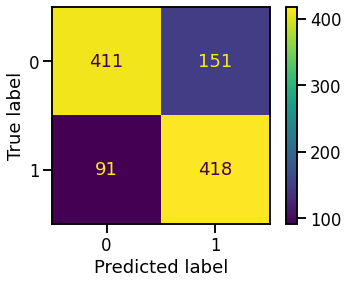

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


              precision    recall  f1-score   support

           0       0.82      0.73      0.77       562
           1       0.73      0.82      0.78       509

    accuracy                           0.77      1071
   macro avg       0.78      0.78      0.77      1071
weighted avg       0.78      0.77      0.77      1071



In [ ]:
clf = DecisionTreeClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_validation)
accuracy = accuracy_score(y_validation, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_validation, test_predictions)
plt.show()

print(classification_report(y_validation,clf.predict(x_validation)))


### Entrenamiento del mejor modelo utilizando folds

In [ ]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train)
y_train2 = np.array(y_train)


for clfi, name in zip([DecisionTreeClassifier(**grid.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

DecisionTreeClassifier(criterion='entropy', max_depth=10)
Precisión test fold 0: 75.04
Precisión test fold 1: 76.52
Precisión test fold 2: 80.15
Precisión test fold 3: 79.16
Precisión test fold 4: 76.92
Avg. accuracy = 77.55797639791876


## Ejecutar modelo prediciendo la salida para entregar

In [ ]:
imputed_test_df = clean_nulls(test_df, IMPUTE_NULLS)
PassengerId = imputed_test_df['PassengerId']
imputed_test_df = fit_columns(imputed_test_df)
encoded_test_df = encode(imputed_test_df)
scaled_test_df = scale_numericals(imputed_test_df)

X_test = scaled_test_df.join(encoded_test_df)
X_test

,Age,FoodCourt,ShoppingMall,Spa,VRDeck,RoomService,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,...,Floor_A,Floor_B,Floor_C,Floor_D,Floor_E,Floor_F,Floor_G,Floor_T,Side_P,Side_S
0,-1.043816,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,1.396469,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.073484,-0.309428,-0.284464,0.435278,-0.248635,-0.347539,-0.720279,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2.371184,-0.310121,-0.158515,-0.307366,1.307603,-0.387879,-0.720279,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.248716,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,-0.720279,-0.133716,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.185584,-0.310121,-0.281315,-0.211097,-0.248635,3.240885,-0.720279,-0.133716,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,1.756484,-0.310121,0.079213,0.018400,-0.248635,0.851658,-0.720279,-0.133716,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
793,2.029684,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,1.396469,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
794,-0.702316,-0.310121,-0.284464,-0.307366,-0.248635,-0.387879,1.396469,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
795,-0.702316,-0.310121,-0.263997,-0.307366,-0.248635,1.014852,-0.720279,-0.133716,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
test_id = PassengerId
test_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [ ]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)